## Truncation Selection Simulations

In [1]:
import os
import sys
import glob
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
from multiprocessing import Pool
from functools import partial
import pandas as pd
import scipy
import pickle
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.patches import Polygon
from matplotlib import cm
import matplotlib as mpl
import matplotlib.colors as mcolors

In [3]:
from cvtk.cvtk import TemporalFreqs, TiledTemporalFreqs
from cvtk.cov import stack_temporal_covariances
import cvtk.slimfile as sf
from cvtk.process_sims import extract_runs, load_pickled, load_stats, CI_polygon, average_runs
from cvtk.process_sims import params_vary_over, col_palette, covs_from_file
from cvtk.gintervals import GenomicIntervals
from cvtk.plots import rep_plot_pca, correction_diagnostic_plot
from cvtk.utils import integerize
from cvtk.cov import stack_replicate_covariances, stack_temporal_covs_by_group

In [4]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (8.0, 4.0)
mpl.rcParams['figure.dpi'] = 200

In [5]:
max_nreps = 20

I've run these with and without marking fixations as NaNs. Keeping fixations leads to some pathologies in the covariances (some of these can be seen without fixations and extreme truncation selection) — covariances become negative.

In [6]:
DATADIR_WF = "../data/sims_intermediate/split_trunc/with_fixations_covs/"
DATADIR_WOF = "../data/sims_intermediate/split_trunc/without_fixations_covs/"
SIMDIR = "../data/sims/split_trunc/"
plt.style.use('plots/buffalo.mplstyle')

## Covariance Under Truncation Selection

Here, we're only looking at 1000 sampled individuals (e.g. no bottleneck), and one population.

In [7]:
converters = dict(N=int, alpha=float, nmu=float, rbp=float, tmu=float,
                  region_length=int, sampleN=int, shifttime=int, tail=float)

trunc_results_wf = load_pickled(DATADIR_WF, converters=converters)
trunc_results_wof = load_pickled(DATADIR_WOF, converters=converters)
# stats are only for full set of data; without fixation data is a test subset
trunc_stats = load_stats(SIMDIR, pattern="split_trunc_1000N_1e-08rbp.*1e-08tmu.*", converters=converters)

In [8]:
params_vary_over(trunc_results_wf)

defaultdict(set,
            {'N': {1000},
             'alpha': {0.01},
             'nmu': {1e-08},
             'rbp': {1e-08},
             'region_length': {50000000},
             'sampleN': {50, 100, 200, 1000},
             'shifttime': {5},
             'shifttype': {'converge', 'diverge', 'single'},
             'tail': {0.01, 0.1, 0.25, 0.5},
             'tmu': {1e-08}})

In [9]:
# assert we've loaded all the data
assert(set(trunc_stats.keys()) == set(trunc_results_wf.keys()))

In [10]:
# get a subset of parameters
converge_1k = {'N': [1000], 
               'shifttype': ['converge'],
               'sampleN': [1000], 
               'tail':[0.1, 0.25, 0.5]}
converge_1k_covs_wf = extract_runs(converge_1k, trunc_results_wf)
converge_1k_covs_wof = extract_runs(converge_1k, trunc_results_wof)
converge_1k_stats = extract_runs(converge_1k, trunc_stats)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


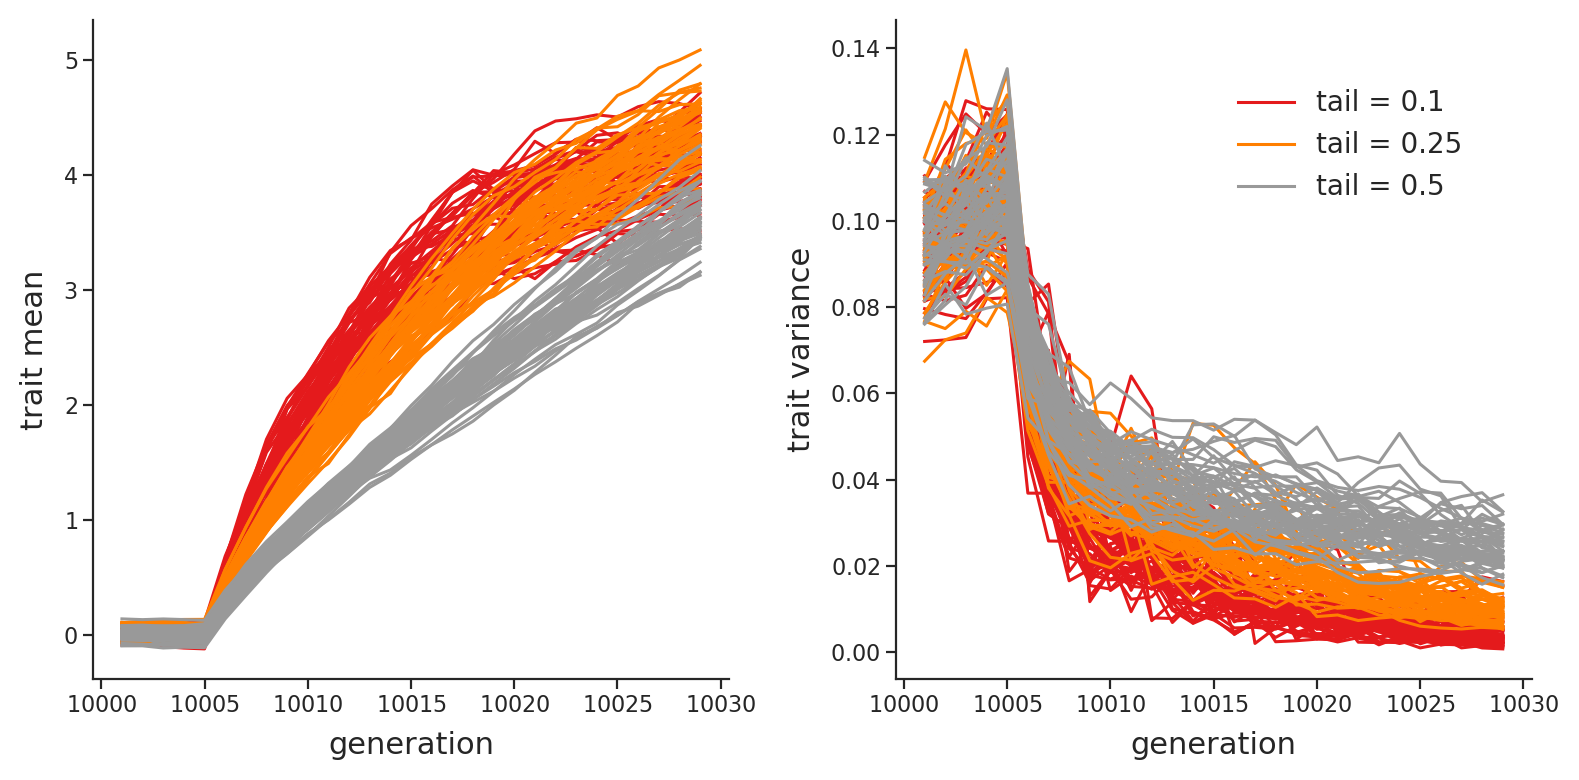

In [11]:
param_covs = params_vary_over(converge_1k_stats)
key = list(converge_1k_stats.keys())[0]
nruns = len(converge_1k_stats[key])

tail_cols = col_palette(param_covs['tail'], cm.Set1)

fig, ax = plt.subplots(ncols=2, nrows=1)

for params, stats in converge_1k_stats.items():
    params = dict(params)
    for r, d in enumerate(stats):
        ds = d[d.generation < 10030]
        lab = f"tail = {params['tail']}" if r == 0 else ""
        ax[0].plot(ds.generation, ds.zbar_1, c=tail_cols[params['tail']], label=lab)
        ax[1].plot(ds.generation, ds.zvar_1, c=tail_cols[params['tail']], label=lab)
        ax[0].set_xlabel("generation")
        ax[1].set_xlabel("generation")
        ax[0].set_ylabel("trait mean")
        ax[1].set_ylabel("trait variance")
plt.tight_layout()
plt.legend(frameon=False)

### Plot Gs

In [12]:
param_covs_wof = params_vary_over(converge_1k_covs_wf)
param_covs_wof

defaultdict(set,
            {'N': {1000},
             'alpha': {0.01},
             'nmu': {1e-08},
             'rbp': {1e-08},
             'region_length': {50000000},
             'sampleN': {1000},
             'shifttime': {5},
             'shifttype': {'converge'},
             'tail': {0.1, 0.25, 0.5},
             'tmu': {1e-08}})

Text(0, 0.5, 'G')

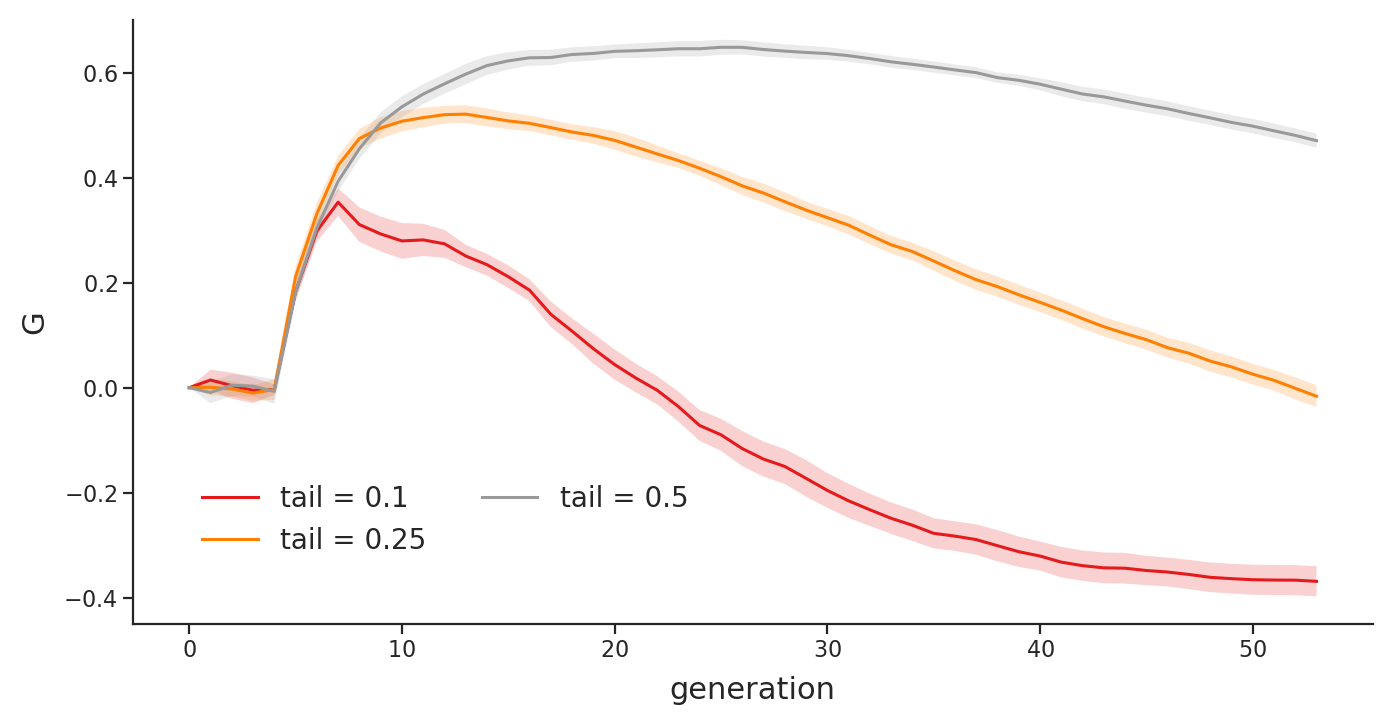

In [13]:
fig, ax = plt.subplots(ncols=1, nrows=1)
tail_cols = col_palette(param_covs_wof['tail'], cm.Set1)

labs = set()
CI_ALPHA = 0.2
cis = dict()

for params, runs in converge_1k_covs_wf.items():
    params = dict(params)
    all = []
    for r, (covs, Gs, dims) in enumerate(runs):
        #lab = params['tail'] if r == 0 else ''
        #ax.plot(Gs[:, 0], c=tail_cols[params['tail']], label=lab)
        #ax.plot(Gs[:, 1], c=tail_cols[params['tail']], label="")
        #ax.set_ylim((-2, 1))
        all.append(Gs)
    label = f"tail = {params['tail']}"
    G = np.stack(all)
    G_mean = G.mean(axis=0)
    ax.plot(G_mean[:, 0], label=label if label not in labs else "", c=tail_cols[params['tail']])
    labs.add(label)    
    sd = np.sqrt(np.var(G, axis=0))
    N = G_mean.shape[0]
    G_CI = np.stack((G_mean - 2 * sd/np.sqrt(N), 
                     G_mean + 2 * sd/np.sqrt(N)))   
    cis[params['tail']] = G_CI, G_mean, sd
    idx = np.logical_and(~np.isnan(G_CI[0, :, 0]), ~np.isnan(G_CI[1, :, 0]))
    G_poly = CI_polygon(np.argwhere(idx), 
                            G_CI[0, idx, 0], G_CI[1, idx, 0],
                            color=tail_cols[params['tail']], alpha=CI_ALPHA,
                            frac=1/100,
                            linewidth=0, smooth=False)    
    ax.add_patch(G_poly)
plt.legend(frameon=False, ncol=2)
plt.xlabel("generation")
plt.ylabel("G")

/home/vsb/miniconda3/envs/cvtk/lib/python3.7/site-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Text(0, 0.5, 'G')

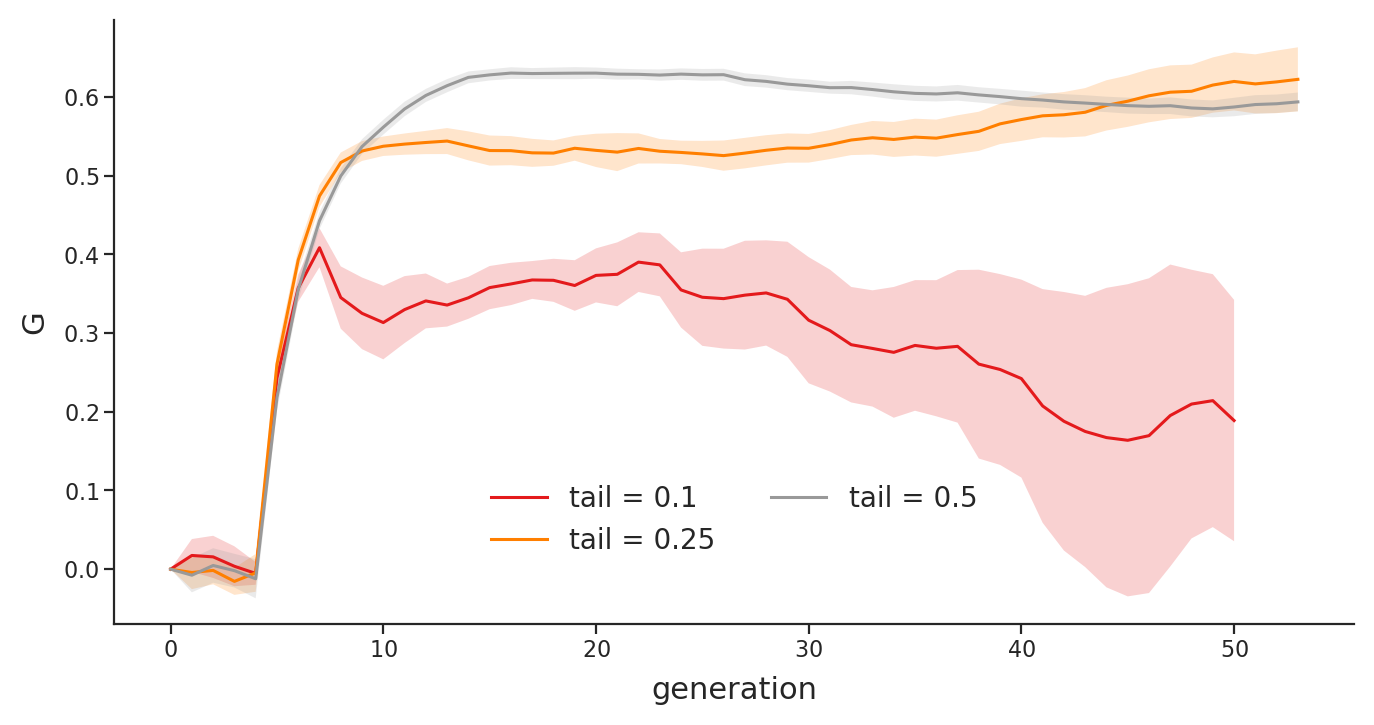

In [14]:
param_covs_wof = params_vary_over(converge_1k_covs_wof)

fig, ax = plt.subplots(ncols=1, nrows=1)
tail_cols = col_palette(param_covs_wof['tail'], cm.Set1)

labs = set()
CI_ALPHA = 0.2
cis = dict()

for params, runs in converge_1k_covs_wof.items():
    params = dict(params)
    all = []
    for r, (covs, Gs, _, dims) in enumerate(runs):
        #lab = params['tail'] if r == 0 else ''
        #ax.plot(Gs[:, 0], c=tail_cols[params['tail']], label=lab)
        #ax.plot(Gs[:, 1], c=tail_cols[params['tail']], label="")
        #ax.set_ylim((-2, 1))
        all.append(Gs)
    label = f"tail = {params['tail']}"
    G = np.stack(all)
    G_mean = G.mean(axis=0)
    ax.plot(G_mean[:, 0], label=label if label not in labs else "", c=tail_cols[params['tail']])
    labs.add(label)    
    sd = np.sqrt(np.var(G, axis=0))
    N = G_mean.shape[0]
    G_CI = np.stack((G_mean - 2 * sd/np.sqrt(N), 
                     G_mean + 2 * sd/np.sqrt(N)))   
    cis[params['tail']] = G_CI, G_mean, sd
    idx = np.logical_and(~np.isnan(G_CI[0, :, 0]), ~np.isnan(G_CI[1, :, 0]))
    G_poly = CI_polygon(np.argwhere(idx), 
                            G_CI[0, idx, 0], G_CI[1, idx, 0],
                            color=tail_cols[params['tail']], alpha=CI_ALPHA,
                            frac=1/100,
                            linewidth=0, smooth=False)    
    ax.add_patch(G_poly)
plt.legend(frameon=False, ncol=2)
plt.xlabel("generation")
plt.ylabel("G")

In [37]:
lowess = sm.nonparametric.lowess

No handles with labels found to put in legend.
/home/vsb/miniconda3/envs/cvtk/lib/python3.7/site-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/vsb/miniconda3/envs/cvtk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


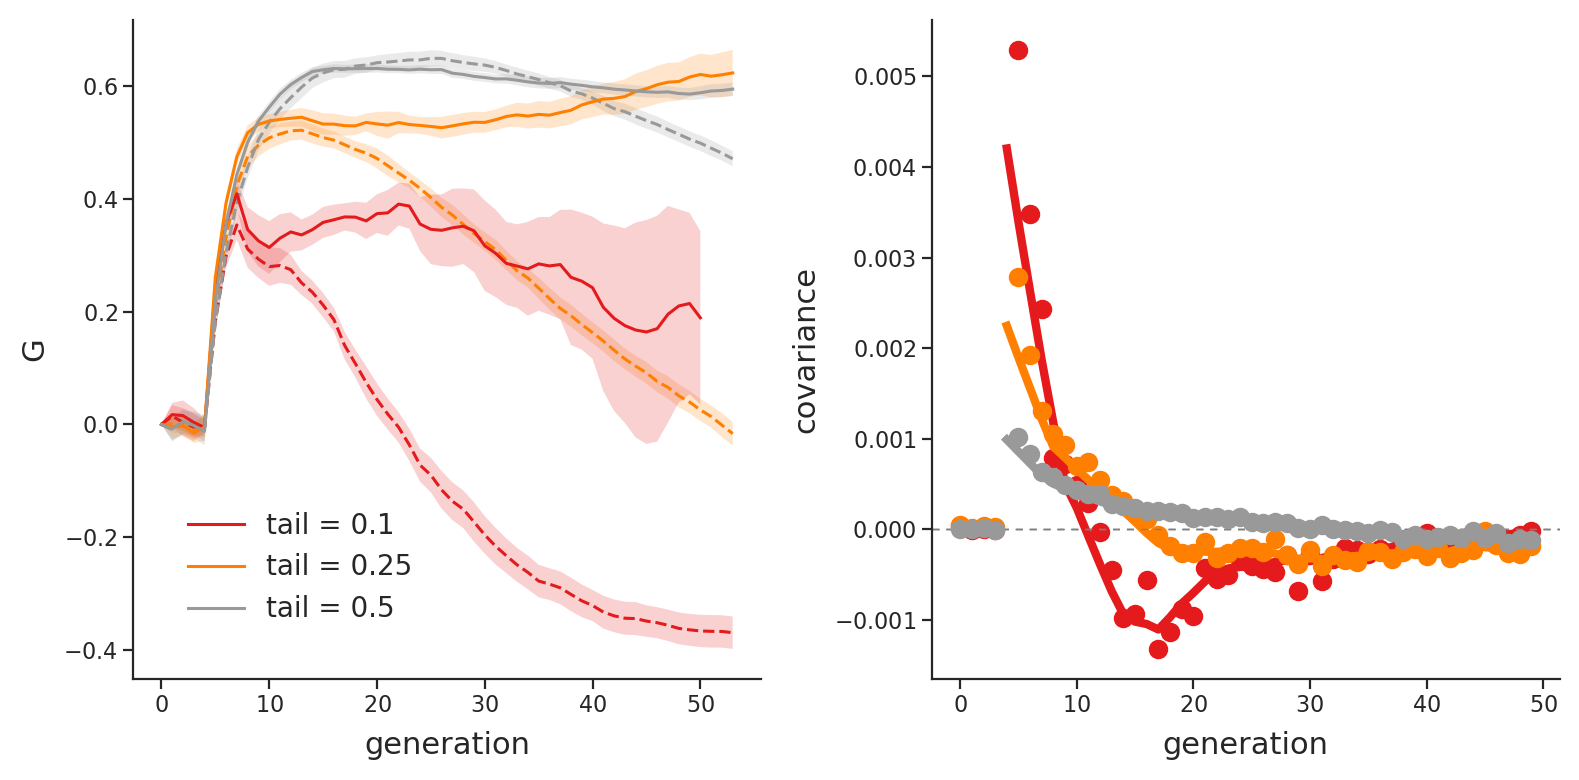

In [47]:
fig, ax = plt.subplots(ncols=2, nrows=1)
tail_cols = col_palette(param_covs_wf['tail'], cm.Set1)

labs = set()
CI_ALPHA = 0.2
cis = dict()

for params, runs in converge_1k_covs_wf.items():
    params = dict(params)
    all = []
    for r, (covs, Gs, dims) in enumerate(runs):
        #lab = params['tail'] if r == 0 else ''
        #ax.plot(Gs[:, 0], c=tail_cols[params['tail']], label=lab)
        #ax.plot(Gs[:, 1], c=tail_cols[params['tail']], label="")
        #ax.set_ylim((-2, 1))
        all.append(Gs)
    label = f"tail = {params['tail']}"
    G = np.stack(all)
    G_mean = G.mean(axis=0)
    ax[0].plot(G_mean[:, 0], '--', 
            c=tail_cols[params['tail']])
    labs.add(label)    
    sd = np.sqrt(np.var(G, axis=0))
    N = G_mean.shape[0]
    G_CI = np.stack((G_mean - 2 * sd/np.sqrt(N), 
                     G_mean + 2 * sd/np.sqrt(N)))   
    cis[params['tail']] = G_CI, G_mean, sd
    idx = np.logical_and(~np.isnan(G_CI[0, :, 0]), ~np.isnan(G_CI[1, :, 0]))
    G_poly = CI_polygon(np.argwhere(idx), 
                            G_CI[0, idx, 0], G_CI[1, idx, 0],
                            color=tail_cols[params['tail']], alpha=CI_ALPHA,
                            frac=1/100,
                            linewidth=0, smooth=False)    
    ax[0].add_patch(G_poly)
plt.legend(frameon=False, ncol=2)
plt.xlabel("generation")
plt.ylabel("G")

# -------------------

param_covs_wof = params_vary_over(converge_1k_covs_wof)

#fig, ax = plt.subplots(ncols=1, nrows=1)
tail_cols = col_palette(param_covs_wof['tail'], cm.Set1)

labs = set()
CI_ALPHA = 0.2
cis = dict()

for params, runs in converge_1k_covs_wof.items():
    params = dict(params)
    all = []
    for r, (covs, Gs, _, dims) in enumerate(runs):
        #lab = params['tail'] if r == 0 else ''
        #ax.plot(Gs[:, 0], c=tail_cols[params['tail']], label=lab)
        #ax.plot(Gs[:, 1], c=tail_cols[params['tail']], label="")
        #ax.set_ylim((-2, 1))
        all.append(Gs)
    label = f"tail = {params['tail']}"
    G = np.stack(all)
    G_mean = G.mean(axis=0)
    ax[0].plot(G_mean[:, 0], label=label if label not in labs else "", c=tail_cols[params['tail']])
    labs.add(label)    
    sd = np.sqrt(np.var(G, axis=0))
    N = G_mean.shape[0]
    G_CI = np.stack((G_mean - 2 * sd/np.sqrt(N), 
                     G_mean + 2 * sd/np.sqrt(N)))   
    cis[params['tail']] = G_CI, G_mean, sd
    idx = np.logical_and(~np.isnan(G_CI[0, :, 0]), ~np.isnan(G_CI[1, :, 0]))
    G_poly = CI_polygon(np.argwhere(idx), 
                            G_CI[0, idx, 0], G_CI[1, idx, 0],
                            color=tail_cols[params['tail']], alpha=CI_ALPHA,
                            frac=1/100,
                            linewidth=0, smooth=False)    
    ax[0].add_patch(G_poly)
ax[0].set_xlabel("generation")
ax[0].set_ylabel("G")
ax[0].legend(loc=(0, 0), frameon=False, ncol=1)
#fig.savefig("plots/fig-G-trunc.pdf", bbox_inches='tight')



# ============

param_covs_wf = params_vary_over(converge_1k_covs_wf)

#fig, ax = plt.subplots(ncols=1, nrows=1)
tail_cols = col_palette(param_covs_wof['tail'], cm.Set1)

stacked_covs_subset_wf = average_runs(converge_1k_covs_wf, has_corr=False, has_var=False)

ref = 4
lightgray, darkgray = (0.6, 0.6, 0.6), (0.1, 0.1, 0.1)
yscale = 1
maxgen = 50
labs = set()
CI_ALPHA = 0.2

for tail in param_covs_wf['tail']:
    d = extract_runs({'tail':[tail]}, stacked_covs_subset_wf)
    for run in list(d.values()):            
        tempcovs = stack_temporal_covariances(run[0].mean(axis=0), run[2][0], run[2][1])
        n = tempcovs[0].shape[0]
        idx = (np.arange(n) != ref) & (np.arange(n) < maxgen)
        ax[1].axhline(0, c='0.5', linewidth=0.5, linestyle=(0, (5, 5)))
        cols = [lightgray if i < ref-1 else darkgray for i in range(maxgen-1)]
        
        selgen = np.arange(ref, maxgen-1)
        ax[1].plot(np.where(idx)[0], yscale * tempcovs[ref, idx, 1], 'o', 
                c=tail_cols[tail])
        fit = lowess(tempcovs[ref, idx, 1][selgen],
                         selgen, frac=1/6, return_sorted=True)
            
        ax[1].plot(fit[:, 0], yscale * fit[:, 1], '-', c=tail_cols[tail], linewidth=3)
        #ax[i, j].set_title(f"L = {L}, Va = {Va}")
        

# param_covs_wof = params_vary_over(converge_1k_covs_wof)
# stacked_covs_subset_wof = average_runs(converge_1k_covs_wof, has_corr=True, has_var=False)


# for tail in param_covs_wof['tail']:
#     d = extract_runs({'tail':[tail]}, stacked_covs_subset_wof)
#     for run in list(d.values()):            
#         tempcovs = stack_temporal_covariances(run[0].mean(axis=0), run[3][0], run[3][1])
#         n = tempcovs[0].shape[0]
#         idx = (np.arange(n) != ref) & (np.arange(n) < maxgen)
#         ax.axhline(0, c='0.5', linewidth=0.5, linestyle=(0, (5, 5)))
#         cols = [lightgray if i < ref-1 else darkgray for i in range(maxgen-1)]
        
#         selgen = np.arange(ref, maxgen-1)
#         #ax.plot(np.where(idx)[0], yscale * tempcovs[ref, idx, 1], 'o', 
#         #        c=tail_cols[tail])
#         fit = lowess(tempcovs[ref, idx, 1][selgen],
#                          selgen, frac=1/3, return_sorted=True)
            
#         ax.plot(fit[:, 0], yscale * fit[:, 1], '--', c=tail_cols[tail], linewidth=3)
#         #ax[i, j].set_title(f"L = {L}, Va = {Va}")


ax[1].set_xlabel("generation")
ax[1].set_ylabel("covariance")
plt.tight_layout()
fig.savefig("plots/fig-both-trunc.pdf", bbox_inches='tight')
